# Соревнование по Классификации. 2 Семестр

## Ссылка на соревнование

https://www.kaggle.com/competitions/urfuaieng2022clf2

## Целевая метрика

F1 > 0.9

In [1]:
#from google.colab import files

In [2]:
#uploaded = files.upload()
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
#!kaggle competitions download -c urfuaieng2022clf2

In [4]:
#!unzip urfuaieng2022clf2.zip

## Dataset Description

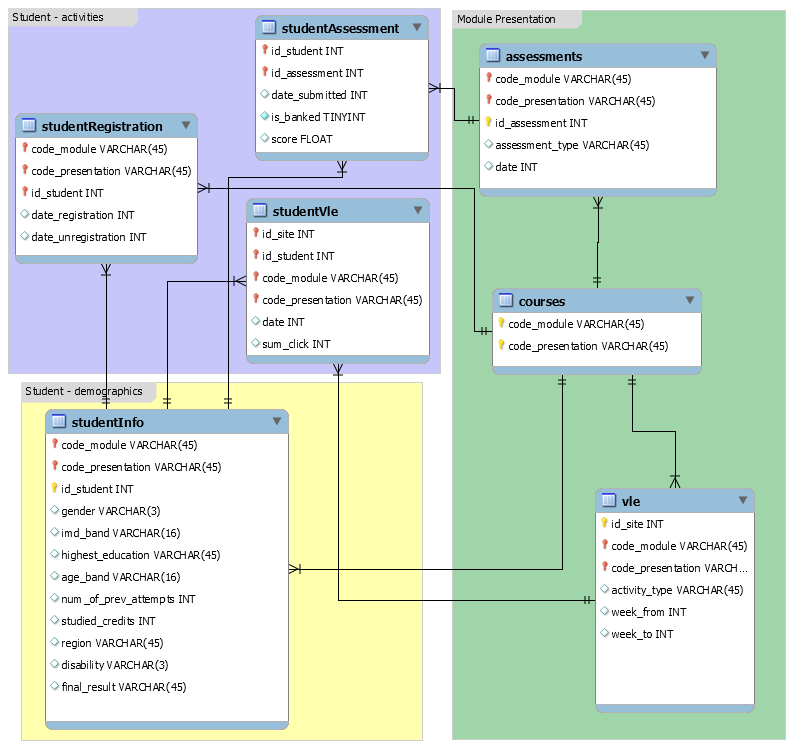

In [5]:
from IPython.display import Image
Image("./Data/k4_model.png", width=620, height=480) 

**Файлы**  
*Которые оригинальные (с небольшими удалениями)*
- assessments.csv - Файл содержит информацию об оценках в модулях-презентациях. Обычно каждая презентация имеет ряд оценок, за которыми следует итоговый экзамен.

- courses.csv - Файл содержит список всех доступных модулей и их презентаций.

- studentInfo.csv - Файл содержит демографическую информацию об учащихся.

- studentRegistration.csv - Файл содержит информацию о времени регистрации студента на презентацию модуля.

- studentVle.csv - Фйал содержит информацию о взаимодействии каждого учащегося с материалами в VLE.

- vle.csv - Файл содержит информацию о доступных материалах в VLE (Virtual Learning Environment). Обычно это html-страницы, pdf-файлы и т. д.  

Студенты имеют доступ к этим материалам в Интернете, и их взаимодействие с материалами записывается.

_**ВАЖНО то что нет файла studentAssessment.csv это не баг, а фича**_

**Которые описывают тренировочную и тестовую выборку**
- Test_Who.csv - перечень id_student, code_modelu и code_presentation для тестовой выборки. ID - внутренний идентификатор для оценки на Kaggle

- Train_Who.csv - перечень id_student, code_modelu и code_presentation для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle

- Train_Target_clf.csv - целевая метрика для тренировочной выборки. ID - внутренний идентификатор для оценки на Kaggle, как в файле Train_Who.csv

- Submission_clf.csv - Пример файла для загрузки, в который проставлен всем незачет(кто знает может использовать для подгонки 👀). ID - внутренний идентификатор для оценки на Kaggle, как в файле Test_Who.csv

### Baseline

Загрузка файла Submission_clf.csv в качестве ответа дало значение метрики **0.34587**

### Функции

Оптимизация объема памяти, занимаемого датасетом

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Import библиотек

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [9]:
# Т.к. переустанавливал анаконду, установим слетевшие библиотеки

In [10]:
#! pip install xgboost

In [11]:
#! pip install catboost

In [12]:
#! pip install lightgbm

In [13]:
#!pip install hyperopt

In [14]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

# 6. Всякие разности
from sklearn.preprocessing import LabelEncoder

In [15]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [16]:
import warnings 
warnings.simplefilter("ignore", UserWarning)

### Считываем файлы в DataFrame

In [17]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentInfo = pd.read_csv('studentInfo.csv')
studentRegistration = pd.read_csv('studentRegistration.csv')
studentVle = pd.read_csv('studentVle.csv')
Submission_clf = pd.read_csv('Submission_clf.csv')
Test_Who = pd.read_csv('Test_Who.csv')
Train_Target_clf = pd.read_csv('Train_Target_clf.csv')
Train_Who = pd.read_csv('Train_Who.csv')
vle = pd.read_csv('vle.csv')

### Первичный анализ данных

**Посмотрим на файлы**

1. assessments

In [18]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [19]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [20]:
assessments.isnull().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [21]:
assessments['date'].value_counts

<bound method IndexOpsMixin.value_counts of 0       19.0
1       54.0
2      117.0
3      166.0
4      215.0
       ...  
201    229.0
202     61.0
203    124.0
204    173.0
205    229.0
Name: date, Length: 206, dtype: float64>

Заменим nan на 0

In [22]:
assessments = assessments.fillna(0)

In [23]:
assessments[assessments['date'] == 0]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,0.0,100.0
11,AAA,2014J,1763,Exam,0.0,100.0
23,BBB,2013B,14990,Exam,0.0,100.0
35,BBB,2013J,15002,Exam,0.0,100.0
47,BBB,2014B,15014,Exam,0.0,100.0
53,BBB,2014J,15025,Exam,0.0,100.0
62,CCC,2014B,24290,Exam,0.0,100.0
63,CCC,2014B,40087,Exam,0.0,100.0
72,CCC,2014J,24299,Exam,0.0,100.0
73,CCC,2014J,40088,Exam,0.0,100.0


In [24]:
duplicateRows = assessments[assessments.duplicated()]
duplicateRows

,code_module,code_presentation,id_assessment,assessment_type,date,weight


In [25]:
assessments['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

In [26]:
assessments.groupby(['code_module','code_presentation', 'assessment_type']).agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation assessment_type              
AAA         2013J             Exam                    100.0
                              TMA                     100.0
            2014J             Exam                    100.0
                              TMA                     100.0
BBB         2013B             CMA                       5.0
                              Exam                    100.0
                              TMA                      95.0
            2013J             CMA                       5.0
                              Exam                    100.0
                              TMA                      95.0
            2014B             CMA                       5.0
                              Exam                    100.0
                              TMA                      95.0
            2014J             Exam                    100.0
                              TMA                     100.0
CCC         2014B             CMA                      25.0
                              Exam                    200.0
                              TMA                      75.0
            2014J             CMA                      25.0
                              Exam                    200.0
                              TMA                      75.0
DDD         2013B             CMA                      25.0
                              Exam                    100.0
                              TMA                      75.0
            2013J             Exam                    100.0
                              TMA                     100.0
            2014B             Exam                    100.0
                              TMA                     100.0
            2014J             Exam                    100.0
                              TMA                     100.0
EEE         2013J             Exam                    100.0
                              TMA                     100.0
            2014B             Exam                    100.0
                              TMA                     100.0
            2014J             Exam                    100.0
                              TMA                     100.0
FFF         2013B             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0
            2013J             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0
            2014B             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0
            2014J             CMA                       0.0
                              Exam                    100.0
                              TMA                     100.0
GGG         2013J             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0
            2014B             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0
            2014J             CMA                       0.0
                              Exam                    100.0
                              TMA                       0.0

*Вывод: пока непонятно что делать, вернемся позднее*

2. courses

In [27]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [28]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [29]:
courses.isnull().sum()

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [30]:
duplicateRows = courses[courses.duplicated()]
duplicateRows

,code_module,code_presentation,module_presentation_length


Посмотрим на длительность каждого модуля с помощью группировки (т.к. тут по 1 значению - проверено за рамками ноутбука, то используем функцию sum)

In [31]:
courses.groupby(['code_module','code_presentation']).sum()

module_presentation_length
code_module code_presentation                            
AAA         2013J                                     268
            2014J                                     269
BBB         2013B                                     240
            2013J                                     268
            2014B                                     234
            2014J                                     262
CCC         2014B                                     241
            2014J                                     269
DDD         2013B                                     240
            2013J                                     261
            2014B                                     241
            2014J                                     262
EEE         2013J                                     268
            2014B                                     241
            2014J                                     269
FFF         2013B                                     240
            2013J                                     268
            2014B                                     241
            2014J                                     269
GGG         2013J                                     261
            2014B                                     241
            2014J                                     269

*Вывод: ничего менять, обогащать не будем, просто занесем в итоговый датасет как есть*

3. studentVle

In [32]:
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [33]:
studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [34]:
assessments.isnull().sum()

code_module          0
code_presentation    0
id_assessment        0
assessment_type      0
date                 0
weight               0
dtype: int64

In [35]:
studentVle['date'].value_counts()

 18     103112
 2      102553
 17     100640
 16      98867
 3       92750
         ...  
-21       1283
 259      1183
 267      1113
 266       955
 269       814
Name: date, Length: 295, dtype: int64

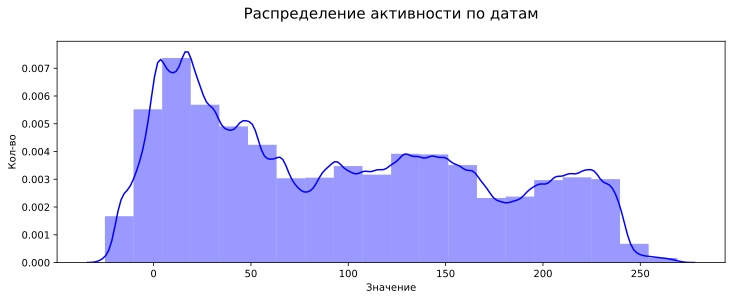

In [36]:
plt.figure(figsize=(12,4))
sns.distplot(studentVle['date'].values, bins=20, color='blue')
plt.title('Распределение активности по датам\n',fontsize=15)
plt.xlabel('Значение'); plt.ylabel('Кол-во');

In [37]:
studentVle.groupby(['code_module','code_presentation', 'id_student', 'id_site']).agg(total_click = ('sum_click',sum))

total_click
code_module code_presentation id_student id_site             
AAA         2013J             11391      546614           138
                                         546644            35
                                         546645            15
                                         546647             9
                                         546650            10
...                                                       ...
GGG         2014J             2684003    897076             1
                                         897121             1
                                         897150             9
                                         897151            17
                                         897152             1

[1960496 rows x 1 columns]

*Вывод: интересно, малоинформативно, надо смотреть по студентам + пока непонятно что делать, вернемся позднее*

4. studentRegistration

In [38]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0
2,AAA,2013J,30268,-92.0
3,AAA,2013J,31604,-52.0
4,AAA,2013J,32885,-176.0


In [39]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


In [40]:
studentRegistration.isnull().sum()

code_module           0
code_presentation     0
id_student            0
date_registration    45
dtype: int64

Заменим nan на 0

In [41]:
studentRegistration = studentRegistration.fillna(0)

In [42]:
#studentRegistration[studentRegistration['date_registration'] == 0]

In [43]:
duplicateRows = studentRegistration[studentRegistration.duplicated()]
duplicateRows

,code_module,code_presentation,id_student,date_registration


In [44]:
studentRegistration.groupby(['code_module','code_presentation']).agg(['count'])

id_student date_registration
                                   count             count
code_module code_presentation                             
AAA         2013J                    383               383
            2014J                    365               365
BBB         2013B                   1767              1767
            2013J                   2237              2237
            2014B                   1613              1613
            2014J                   2292              2292
CCC         2014B                   1936              1936
            2014J                   2498              2498
DDD         2013B                   1303              1303
            2013J                   1938              1938
            2014B                   1228              1228
            2014J                   1803              1803
EEE         2013J                   1052              1052
            2014B                    694               694
            2014J                   1188              1188
FFF         2013B                   1614              1614
            2013J                   2283              2283
            2014B                   1500              1500
            2014J                   2365              2365
GGG         2013J                    952               952
            2014B                    833               833
            2014J                    749               749

*Вывод: что-нибудь выжмем я думаю, но пока непонятно что делать, вернемся позднее*

5. vle

In [45]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [46]:
vle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [47]:
vle.isnull().sum()

id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64

Заменим nan на 0

In [48]:
vle = vle.fillna(0)

In [49]:
duplicateRows = vle[vle.duplicated()]
duplicateRows

,id_site,code_module,code_presentation,activity_type,week_from,week_to


In [50]:
vle.groupby(['code_module','code_presentation', 'activity_type']).sum()

id_site  week_from  week_to
code_module code_presentation activity_type                              
AAA         2013J             dataplus        2188194        0.0      0.0
                              forumng         8199778        0.0      0.0
                              glossary        1093321        0.0      0.0
                              homepage         546614        0.0      0.0
                              oucollaborate   1094133        0.0      0.0
...                                               ...        ...      ...
GGG         2014J             homepage         896943        0.0      0.0
                              oucontent      23321275        0.0      0.0
                              quiz            7175617        0.0      0.0
                              resource       56516490        7.0      7.0
                              subpage         4485760        0.0      0.0

[232 rows x 3 columns]

*Вывод: повторюсь повторяться, интересно, нопока непонятно что делать, вернемся позднее*

## Начнем пилить слона по кусочкам

### Создадим из набора таблиц объединенный датасет

Начнем с изучения информации о студентах

In [51]:
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


In [52]:
studentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


**Вывод:** *видим много категориальных признаков, скорее всено будем использовать catboost или аналогичные модели*

Проверим повторение id_student

In [53]:
studentInfo.id_student.value_counts()

584077     5
542562     4
546400     4
596620     4
2681198    4
          ..
608464     1
607411     1
606828     1
606663     1
2684003    1
Name: id_student, Length: 28785, dtype: int64

In [54]:
studentInfo[studentInfo['id_student'] == 584077]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
9587,CCC,2014B,584077,M,North Western Region,A Level or Equivalent,20-30%,0-35,0,150,N
11525,CCC,2014J,584077,M,North Western Region,A Level or Equivalent,20-30%,0-35,1,90,N
15596,DDD,2013J,584077,M,North Western Region,A Level or Equivalent,20-30%,0-35,0,150,N
16828,DDD,2014B,584077,M,North Western Region,A Level or Equivalent,20-30%,0-35,1,150,N
18139,DDD,2014J,584077,M,North Western Region,A Level or Equivalent,20-30%,0-35,2,90,N


In [55]:
Train_Who[Train_Who['id_student'] == 584077]

,ID,id_student,code_module,code_presentation
3350,3350,584077,DDD,2014B
10689,10689,584077,DDD,2014J
23226,23226,584077,DDD,2013J
24158,24158,584077,CCC,2014B


**Вывод:** *объединять будем по нескольким полям одновременно*

Проверим датасет на пропуски значений

In [56]:
studentInfo.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
dtype: int64

In [57]:
studentInfo.imd_band.unique()

array(['90-100%', '20-30%', '30-40%', '50-60%', '80-90%', '70-80%', nan,
       '60-70%', '40-50%', '10-20', '0-10%'], dtype=object)

In [58]:
studentInfo.imd_band.value_counts()

20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: imd_band, dtype: int64

Заменим nan на 0% и исправим опечатку в '10-20'(да, глаз режет, я максималист)

In [59]:
studentInfo = studentInfo.fillna('0%')

In [60]:
studentInfo.imd_band = np.where(studentInfo.imd_band =='10-20', '10-20%', studentInfo.imd_band)

In [61]:
studentInfo.imd_band.value_counts()

20-30%     3654
30-40%     3539
10-20%     3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
0%         1111
Name: imd_band, dtype: int64

In [62]:
studentInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              32593 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


Все, супер, тут кажется, что все поправили

**Теперь пойдем с конца, сметчим датафреймы по полям ID и 'id_student', 'code_module', 'code_presentation':**  
- Train_Who, Train_Target_clf, studentInfo  
- Test_Who, studentInfo  

In [63]:
Train_Who.head(2)

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J


In [64]:
Train_Who.shape

(26074, 4)

In [65]:
Test_Who.head(2)

,ID,id_student,code_module,code_presentation
0,26074,2588655,DDD,2014J
1,26075,543628,CCC,2014B


In [66]:
Test_Who.shape

(6519, 4)

In [67]:
Train_Target_clf.head(2)

,ID,final_result
0,0,1
1,1,0


In [68]:
Train_Target_clf.shape

(26074, 2)

In [69]:
df_train = pd.DataFrame()
df_train = Train_Target_clf.merge(Train_Who, how='inner', on='ID')\
.merge(studentInfo, how='inner', on=['id_student', 'code_module', 'code_presentation'])
df_train.head()

,ID,final_result,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,0,1,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N
1,1,0,606593,DDD,2013J,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N
2,2,1,1674799,CCC,2014J,M,South Region,HE Qualification,70-80%,55<=,0,60,N
3,3,0,195246,FFF,2014J,M,West Midlands Region,Lower Than A Level,10-20%,0-35,0,60,N
4,4,0,582080,FFF,2013J,M,South East Region,Lower Than A Level,10-20%,35-55,0,60,N


In [70]:
df_train.shape

(26074, 13)

In [71]:
df_test = pd.DataFrame()
df_test = Test_Who.merge(studentInfo, how='inner', on=['id_student', 'code_module', 'code_presentation'])
df_test.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N
1,26075,543628,CCC,2014B,M,North Western Region,HE Qualification,0-10%,35-55,0,90,N
2,26076,387276,BBB,2013B,F,North Western Region,Lower Than A Level,50-60%,35-55,1,180,N
3,26077,692219,CCC,2014J,M,South Region,A Level or Equivalent,20-30%,0-35,0,90,N
4,26078,516212,BBB,2013J,F,East Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,N


In [72]:
df_test.shape

(6519, 12)

**Добавим информацию о длительности курса**

In [73]:
df_train = df_train.merge(courses, how='inner', on=['code_module', 'code_presentation'])
df_train.head()

,ID,final_result,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,0,1,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,241
1,14,1,628642,DDD,2014B,M,North Western Region,Lower Than A Level,20-30%,35-55,0,60,N,241
2,29,1,266922,DDD,2014B,M,North Region,Lower Than A Level,80-90%,0-35,2,120,N,241
3,39,0,548500,DDD,2014B,M,Wales,A Level or Equivalent,50-60%,35-55,1,120,N,241
4,48,1,2503273,DDD,2014B,M,Wales,Lower Than A Level,10-20%,35-55,0,60,N,241


In [74]:
df_train.shape

(26074, 14)

In [75]:
df_test = df_test.merge(courses, how='inner', on=['code_module', 'code_presentation'])
df_test.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,262
1,26100,592214,DDD,2014J,F,South Region,A Level or Equivalent,80-90%,0-35,0,60,N,262
2,26124,589585,DDD,2014J,F,East Midlands Region,Lower Than A Level,40-50%,0-35,0,60,N,262
3,26138,679179,DDD,2014J,M,Scotland,HE Qualification,20-30%,0-35,0,90,N,262
4,26151,685085,DDD,2014J,M,North Region,Post Graduate Qualification,0%,35-55,0,60,N,262


In [76]:
df_test.shape

(6519, 13)

**Добавим информацию о дате регистрации студента на курс**

In [77]:
df_train = df_train.merge(studentRegistration, how='inner', on=['code_module', 'code_presentation', 'id_student'])
df_train.head()

,ID,final_result,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration
0,0,1,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,241,-36.0
1,14,1,628642,DDD,2014B,M,North Western Region,Lower Than A Level,20-30%,35-55,0,60,N,241,-22.0
2,29,1,266922,DDD,2014B,M,North Region,Lower Than A Level,80-90%,0-35,2,120,N,241,-110.0
3,39,0,548500,DDD,2014B,M,Wales,A Level or Equivalent,50-60%,35-55,1,120,N,241,-95.0
4,48,1,2503273,DDD,2014B,M,Wales,Lower Than A Level,10-20%,35-55,0,60,N,241,-78.0


In [78]:
df_train.shape

(26074, 15)

In [79]:
df_test = df_test.merge(studentRegistration, how='inner', on=['code_module', 'code_presentation', 'id_student'])
df_test.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,262,-92.0
1,26100,592214,DDD,2014J,F,South Region,A Level or Equivalent,80-90%,0-35,0,60,N,262,-94.0
2,26124,589585,DDD,2014J,F,East Midlands Region,Lower Than A Level,40-50%,0-35,0,60,N,262,-162.0
3,26138,679179,DDD,2014J,M,Scotland,HE Qualification,20-30%,0-35,0,90,N,262,-59.0
4,26151,685085,DDD,2014J,M,North Region,Post Graduate Qualification,0%,35-55,0,60,N,262,-39.0


In [80]:
df_test.shape

(6519, 14)

**Добавим информацию об оценках в модулях-презентациях**

In [81]:
a = assessments.groupby(['code_module','code_presentation', 'assessment_type']).agg(total_weight = ('weight',sum)).reset_index()

In [82]:
a = a.pivot(index=["code_module", "code_presentation"], columns=["assessment_type"], values="total_weight").reset_index()

In [83]:
a = a.fillna(0)
a.head()

assessment_type,code_module,code_presentation,CMA,Exam,TMA
0,AAA,2013J,0.0,100.0,100.0
1,AAA,2014J,0.0,100.0,100.0
2,BBB,2013B,5.0,100.0,95.0
3,BBB,2013J,5.0,100.0,95.0
4,BBB,2014B,5.0,100.0,95.0


In [84]:
df_train = df_train.merge(a, how='inner', on=['code_module', 'code_presentation'])
df_train.head()

,ID,final_result,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration,CMA,Exam,TMA
0,0,1,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,241,-36.0,0.0,100.0,100.0
1,14,1,628642,DDD,2014B,M,North Western Region,Lower Than A Level,20-30%,35-55,0,60,N,241,-22.0,0.0,100.0,100.0
2,29,1,266922,DDD,2014B,M,North Region,Lower Than A Level,80-90%,0-35,2,120,N,241,-110.0,0.0,100.0,100.0
3,39,0,548500,DDD,2014B,M,Wales,A Level or Equivalent,50-60%,35-55,1,120,N,241,-95.0,0.0,100.0,100.0
4,48,1,2503273,DDD,2014B,M,Wales,Lower Than A Level,10-20%,35-55,0,60,N,241,-78.0,0.0,100.0,100.0


In [85]:
df_train.shape

(26074, 18)

In [86]:
df_test = df_test.merge(a, how='inner', on=['code_module', 'code_presentation'])
df_test.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration,CMA,Exam,TMA
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,262,-92.0,0.0,100.0,100.0
1,26100,592214,DDD,2014J,F,South Region,A Level or Equivalent,80-90%,0-35,0,60,N,262,-94.0,0.0,100.0,100.0
2,26124,589585,DDD,2014J,F,East Midlands Region,Lower Than A Level,40-50%,0-35,0,60,N,262,-162.0,0.0,100.0,100.0
3,26138,679179,DDD,2014J,M,Scotland,HE Qualification,20-30%,0-35,0,90,N,262,-59.0,0.0,100.0,100.0
4,26151,685085,DDD,2014J,M,North Region,Post Graduate Qualification,0%,35-55,0,60,N,262,-39.0,0.0,100.0,100.0


In [87]:
df_test.shape

(6519, 17)

### Следующим шагом консолидируем активности студентов в различных ресурсах

In [88]:
studentVle

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


In [89]:
vle

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,0.0,0.0
1,546712,AAA,2013J,oucontent,0.0,0.0
2,546998,AAA,2013J,resource,0.0,0.0
3,546888,AAA,2013J,url,0.0,0.0
4,547035,AAA,2013J,resource,0.0,0.0
...,...,...,...,...,...,...
6359,897063,GGG,2014J,resource,0.0,0.0
6360,897109,GGG,2014J,resource,0.0,0.0
6361,896965,GGG,2014J,oucontent,0.0,0.0
6362,897060,GGG,2014J,resource,0.0,0.0


In [90]:
df_vle = studentVle.merge(vle, how='inner', on=['code_module', 'code_presentation', 'id_site'])
df_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type,week_from,week_to
0,AAA,2013J,28400,546652,-10,4,forumng,0.0,0.0
1,AAA,2013J,28400,546652,-10,1,forumng,0.0,0.0
2,AAA,2013J,28400,546652,-10,1,forumng,0.0,0.0
3,AAA,2013J,28400,546652,-10,8,forumng,0.0,0.0
4,AAA,2013J,30268,546652,-10,3,forumng,0.0,0.0


In [91]:
b = df_vle.groupby(['code_module','code_presentation', 'id_student'])\
.agg(mean_date = ('date',np.mean), sum_click = ('sum_click',sum)).reset_index()

In [92]:
b = b.fillna(0)
b.head()

,code_module,code_presentation,id_student,mean_date,sum_click
0,AAA,2013J,11391,102.132653,934
1,AAA,2013J,28400,86.993023,1435
2,AAA,2013J,30268,2.355263,281
3,AAA,2013J,31604,106.147813,2158
4,AAA,2013J,32885,91.934659,1034


**Добавим информацию об активностях студентов**

In [93]:
df_train = df_train.merge(b, how='left', on=['code_module', 'code_presentation', 'id_student'])
df_train.head()

,ID,final_result,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration,CMA,Exam,TMA,mean_date,sum_click
0,0,1,464685,DDD,2014B,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,241,-36.0,0.0,100.0,100.0,110.194958,1694.0
1,14,1,628642,DDD,2014B,M,North Western Region,Lower Than A Level,20-30%,35-55,0,60,N,241,-22.0,0.0,100.0,100.0,63.151292,644.0
2,29,1,266922,DDD,2014B,M,North Region,Lower Than A Level,80-90%,0-35,2,120,N,241,-110.0,0.0,100.0,100.0,86.753788,684.0
3,39,0,548500,DDD,2014B,M,Wales,A Level or Equivalent,50-60%,35-55,1,120,N,241,-95.0,0.0,100.0,100.0,26.375000,545.0
4,48,1,2503273,DDD,2014B,M,Wales,Lower Than A Level,10-20%,35-55,0,60,N,241,-78.0,0.0,100.0,100.0,101.822917,8105.0


In [94]:
df_train.shape

(26074, 20)

In [95]:
df_train = df_train.fillna(0)

In [96]:
df_test = df_test.merge(b, how='left', on=['code_module', 'code_presentation', 'id_student'])
df_test.head()

,ID,id_student,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,date_registration,CMA,Exam,TMA,mean_date,sum_click
0,26074,2588655,DDD,2014J,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,262,-92.0,0.0,100.0,100.0,139.425532,297.0
1,26100,592214,DDD,2014J,F,South Region,A Level or Equivalent,80-90%,0-35,0,60,N,262,-94.0,0.0,100.0,100.0,92.110845,8669.0
2,26124,589585,DDD,2014J,F,East Midlands Region,Lower Than A Level,40-50%,0-35,0,60,N,262,-162.0,0.0,100.0,100.0,113.461717,1114.0
3,26138,679179,DDD,2014J,M,Scotland,HE Qualification,20-30%,0-35,0,90,N,262,-59.0,0.0,100.0,100.0,10.075000,166.0
4,26151,685085,DDD,2014J,M,North Region,Post Graduate Qualification,0%,35-55,0,60,N,262,-39.0,0.0,100.0,100.0,47.287356,355.0


In [97]:
df_test = df_test.fillna(0)

In [98]:
df_test.shape

(6519, 19)

In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          26074 non-null  int64  
 1   final_result                26074 non-null  int64  
 2   id_student                  26074 non-null  int64  
 3   code_module                 26074 non-null  object 
 4   code_presentation           26074 non-null  object 
 5   gender                      26074 non-null  object 
 6   region                      26074 non-null  object 
 7   highest_education           26074 non-null  object 
 8   imd_band                    26074 non-null  object 
 9   age_band                    26074 non-null  object 
 10  num_of_prev_attempts        26074 non-null  int64  
 11  studied_credits             26074 non-null  int64  
 12  disability                  26074 non-null  object 
 13  module_presentation_length  260

In [100]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 0 to 6518
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          6519 non-null   int64  
 1   id_student                  6519 non-null   int64  
 2   code_module                 6519 non-null   object 
 3   code_presentation           6519 non-null   object 
 4   gender                      6519 non-null   object 
 5   region                      6519 non-null   object 
 6   highest_education           6519 non-null   object 
 7   imd_band                    6519 non-null   object 
 8   age_band                    6519 non-null   object 
 9   num_of_prev_attempts        6519 non-null   int64  
 10  studied_credits             6519 non-null   int64  
 11  disability                  6519 non-null   object 
 12  module_presentation_length  6519 non-null   int64  
 13  date_registration           6519 

### Создание модели

Выберем категориальные и числовые переменные, участвующие в расчетах (прошлые результаты показали, что больше не значит лучше):

In [101]:
cat_col = ['gender', 'region', 'imd_band', 'age_band', 'disability'] 
num_col = ['num_of_prev_attempts', 'studied_credits','date_registration', 'mean_date','sum_click']
cols = cat_col + num_col

In [102]:
df_tr = df_train[cols]
df_tr.head()

,gender,region,imd_band,age_band,disability,num_of_prev_attempts,studied_credits,date_registration,mean_date,sum_click
0,F,East Anglian Region,50-60%,0-35,N,1,70,-36.0,110.194958,1694.0
1,M,North Western Region,20-30%,35-55,N,0,60,-22.0,63.151292,644.0
2,M,North Region,80-90%,0-35,N,2,120,-110.0,86.753788,684.0
3,M,Wales,50-60%,35-55,N,1,120,-95.0,26.375000,545.0
4,M,Wales,10-20%,35-55,N,0,60,-78.0,101.822917,8105.0


In [103]:
df_te = df_test[cols]
df_te.head()

,gender,region,imd_band,age_band,disability,num_of_prev_attempts,studied_credits,date_registration,mean_date,sum_click
0,M,Scotland,50-60%,0-35,N,2,60,-92.0,139.425532,297.0
1,F,South Region,80-90%,0-35,N,0,60,-94.0,92.110845,8669.0
2,F,East Midlands Region,40-50%,0-35,N,0,60,-162.0,113.461717,1114.0
3,M,Scotland,20-30%,0-35,N,0,90,-59.0,10.075000,166.0
4,M,North Region,0%,35-55,N,0,60,-39.0,47.287356,355.0


Применим one-hot-encoding к категориальным данным

In [104]:
df_tr = pd.get_dummies(df_tr, columns=cat_col)
df_tr.head()

,num_of_prev_attempts,studied_credits,date_registration,mean_date,sum_click,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,...,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,1,70,-36.0,110.194958,1694.0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
1,0,60,-22.0,63.151292,644.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,2,120,-110.0,86.753788,684.0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
3,1,120,-95.0,26.375000,545.0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,0,60,-78.0,101.822917,8105.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [105]:
df_te = pd.get_dummies(df_te, columns=cat_col)
df_te.head()

,num_of_prev_attempts,studied_credits,date_registration,mean_date,sum_click,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,...,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,2,60,-92.0,139.425532,297.0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,0,60,-94.0,92.110845,8669.0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0,60,-162.0,113.461717,1114.0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,0,90,-59.0,10.075000,166.0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,60,-39.0,47.287356,355.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Применим MinMaxScaler к числовым признакам

In [106]:
def get_scale(df,num_col, model):
    scal = model.fit_transform(df[num_col])
    df[num_col] = scal
    return df
df_tr = get_scale(df_tr, num_col, MinMaxScaler())

In [107]:
def get_scale(df,num_col, model):
    scal = model.fit_transform(df[num_col])
    df[num_col] = scal
    return df
df_te = get_scale(df_te, num_col, MinMaxScaler())

In [108]:
TARGET_NAME = 'final_result'

In [109]:
X = df_tr
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=13)

In [110]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [111]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)

In [112]:
grid_space={'max_features': [4, 7, 10, 13], 
            'min_samples_leaf': [1, 3, 5, 7], 
            'max_depth': [5,10,15,20]}

In [113]:
%%time
greed_search = GridSearchCV(forest,param_grid=grid_space,cv=skf, scoring='f1', verbose = 1, return_train_score=True)
model_greed_search = greed_search.fit(X_train, y_train)

Fitting 6 folds for each of 64 candidates, totalling 384 fits
CPU times: total: 13min 10s
Wall time: 13min 12s


In [114]:
print(f'Лучшие параметры: {model_greed_search.best_params_}')
print(f'Best score is: {model_greed_search.best_score_}')

Лучшие параметры: {'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 3}
Best score is: 0.907115215780541


In [115]:
y_train_pred = model_greed_search.predict(X_train)
y_test_pred = model_greed_search.predict(X_test)
y_test_pred_probs = model_greed_search.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9662
           1       0.88      0.97      0.93      8589

    accuracy                           0.93     18251
   macro avg       0.93      0.93      0.93     18251
weighted avg       0.93      0.93      0.93     18251

TEST

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4099
           1       0.87      0.96      0.91      3724

    accuracy                           0.91      7823
   macro avg       0.91      0.91      0.91      7823
weighted avg       0.91      0.91      0.91      7823

CONFUSION MATRIX

col_0            0     1
final_result            
0             3547   552
1              159  3565


Результат не ахти, попробуем подобрать гиперпараметры

In [116]:
print('f1 score', f1_score(y_train, y_train_pred))

f1 score 0.9277642366496787


In [117]:
print('f1 score', f1_score(y_test, y_test_pred))

f1 score 0.9093227904604005


###  Применим обученную модель к тестовому набору данных

In [118]:
df_te

,num_of_prev_attempts,studied_credits,date_registration,mean_date,sum_click,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,...,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,0.4,0.048,0.530414,0.621269,0.014061,0,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
1,0.0,0.048,0.525547,0.442494,0.410406,1,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0.0,0.048,0.360097,0.523167,0.052739,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,0.0,0.096,0.610706,0.132528,0.007859,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,0.048,0.659367,0.273132,0.016806,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6514,0.0,0.048,0.542579,0.494742,0.051129,0,1,0,0,0,...,0,0,0,0,1,0,0,1,1,0
6515,0.0,0.048,0.649635,0.500067,0.110922,1,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
6516,0.0,0.336,0.287105,0.160923,0.014345,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6517,0.0,0.048,0.581509,0.511733,0.186006,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [119]:
df_te.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 0 to 6518
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   num_of_prev_attempts         6519 non-null   float64
 1   studied_credits              6519 non-null   float64
 2   date_registration            6519 non-null   float64
 3   mean_date                    6519 non-null   float64
 4   sum_click                    6519 non-null   float64
 5   gender_F                     6519 non-null   uint8  
 6   gender_M                     6519 non-null   uint8  
 7   region_East Anglian Region   6519 non-null   uint8  
 8   region_East Midlands Region  6519 non-null   uint8  
 9   region_Ireland               6519 non-null   uint8  
 10  region_London Region         6519 non-null   uint8  
 11  region_North Region          6519 non-null   uint8  
 12  region_North Western Region  6519 non-null   uint8  
 13  region_Scotland   

In [121]:
test_preds = model_greed_search.predict(df_te)

In [122]:
test_preds

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

### Сохраним полученные предсказания

In [123]:
Submission_clf['final_result'] = test_preds

In [124]:
Submission_clf

,ID,final_result
0,26074,1
1,26075,1
2,26076,1
3,26077,0
4,26078,0
...,...,...
6514,32588,1
6515,32589,1
6516,32590,0
6517,32591,1


In [125]:
Submission_clf.to_csv('UrFU_AI_Eng_2022_Clf_03062023.csv', index=False)

**Результат на лидерборде: 0.90274**

Подтверждение:

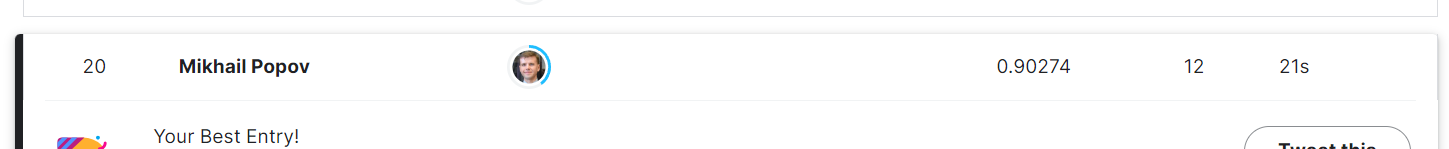

In [126]:
Image("./Data/2_kaggle1_1.png", width=620, height=480) 

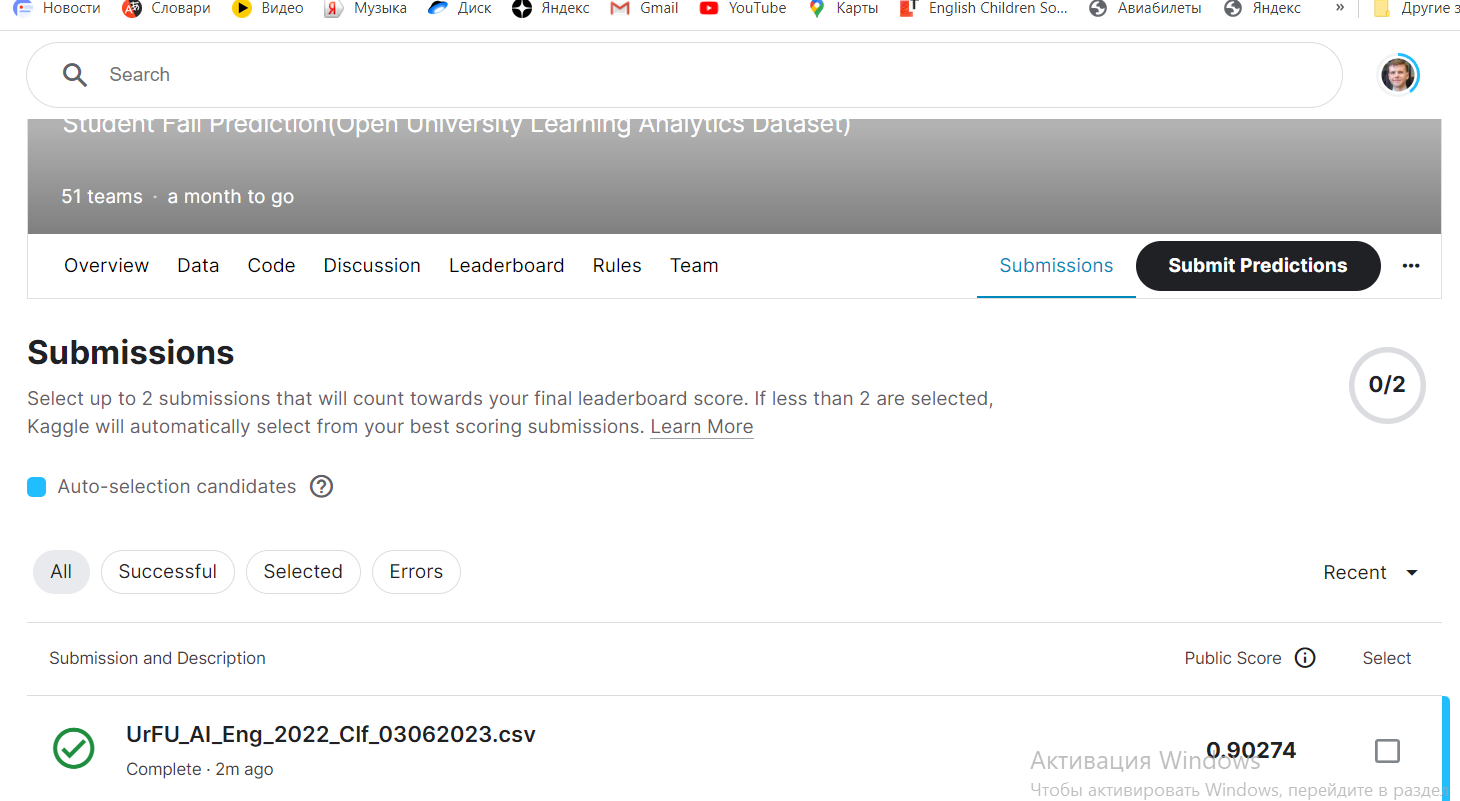

In [127]:
Image("./Data/2_kaggle1_2.png", width=620, height=480) 